In [4]:
import pandas as pd
import numpy as np
import seaborn as sn 
import os

# Load datasets
os.chdir('/Users/daniellee/Desktop/Kaggle/jobs_code_demo/data/stackoverflow_data/')
train = pd.read_csv('cleaned/df_cleaned.csv')
test  = pd.read_csv('cleaned/test_cleaned.csv')

# Add separations in the combined columns
train['combined'] = train.title.str.cat(train.content, sep=' ')
test['combined'] = test.title.str.cat(test.content, sep=' ')

# Remove NaN value
train = train.fillna('')
test = test.fillna('')

# Change tags 

In [5]:
from ast import literal_eval

train['tags'] = [literal_eval(i) for i in train.tags] 

In [6]:
# Is content size and tags count positively correlated?

# Content Size
train['content_size'] = train.content.apply(lambda df: len(df.split())) 
test['content_size'] = test.content.apply(lambda df: len(df.split()))  

# Title Size
train['title_size'] = train.title.apply(lambda df: len(df.split())) 
test['title_size'] = test.title.apply(lambda df: len(df.split()))

# Tags Size
train['tags_size'] = train.tags.apply(lambda df: len(df))

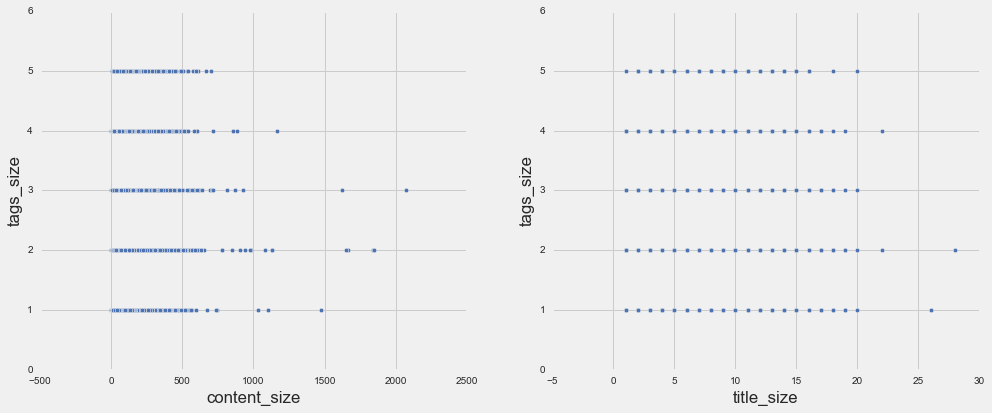

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

f, (ax, ax1) = plt.subplots(figsize=(15,6), nrows=1,ncols=2)
train.plot(kind='scatter', x='content_size', y='tags_size', ax=ax)
train.plot(kind='scatter', x='title_size', y='tags_size', ax=ax1)

In [8]:
# How many words found in title are found in tags?
train['TitleNTags'] = [len(list(set(title.split()).intersection(set(tags)))) for title, tags in zip(train.title, train.tags)]

# What about for content? 
train['ContentNTags'] = [len(list(set(content.split()).intersection(set(tags)))) for content, tags in zip(train.content, train.tags)]

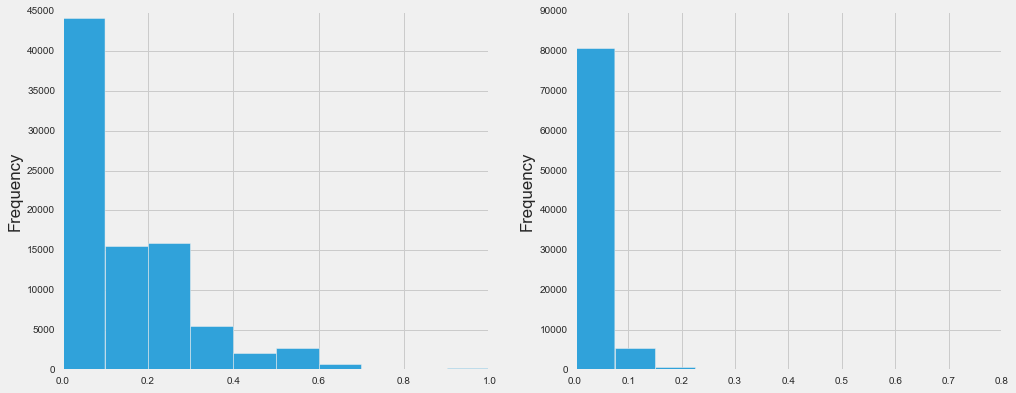

In [9]:
f, (ax, ax1) = plt.subplots(figsize=(15,6), nrows=1,ncols=2)

from contextlib import suppress

with suppress(Exception):
    train.apply(lambda df: df['TitleNTags'] / df['title_size'], axis=1).plot(kind='hist', x='Pct of Hit in Title', ax=ax)
    train[train.content != ''].apply(lambda df: df['ContentNTags'] / df['content_size'], axis=1).plot(kind='hist', x='Pct of Hit in Content', ax=ax1)

In [10]:
# Weigthed TFDW Model 
from gensim import corpora, models, similarities
from operator import itemgetter

# Title ** 2 + Content ** 1 = Final TFDW Score per Word 

def tfdw_pred(df, col):
    # Tokenize the combined column in test
    tCorpus = list(df[col].str.split())

    # Fetch id for each word
    idDict = corpora.Dictionary(tCorpus)

    # Get the reverse key-value mapping 
    inv_Dict = {v: k for v, k in idDict.items()}

    # Transform tCorpus into vector form
    vCorpus = [idDict.doc2bow(tokens) for tokens in tCorpus]

    # Fit TFIDF
    tfidf = models.TfidfModel(vCorpus)

    topK = 4
    tags = []
    for dc in tfidf[vCorpus]:

        idscore = list(map(itemgetter(0), sorted(dc, key=itemgetter(1), reverse=True)[:topK]))
        wordscore = [inv_Dict[wrd] for wrd in idscore]
        tags.append(' '.join(wordscore))
        
    return pd.Series(tags)

train['title_pred'] = tfdw_pred(train, 'title')
train['content_pred'] = tfdw_pred(train, 'content')
train['combined_pred'] = tfdw_pred(train, 'combined')

In [20]:
# Tags predictions based on title, content and combined TFDW models.
train[['title_pred','content_pred','combined_pred','tags']].head()

,title_pred,content_pred,combined_pred,tags
0,criticality ribosome prokaryotic codon,translation 7b observable prokaryotic,translation prokaryotic ribosome codon,"[ribosome, binding-sites, translation, synthet..."
1,prevented rnase contamination experiments,rnase depc pipette degradation,rnase contamination rna depc,"[rna, biochemistry]"
2,clustered lymphocyte groups sizes,lymphocytes diameter tortora 14,lymphocytes clustered groups sizes,"[immunology, cell-biology, hematology]"
3,dosed antibiotic lb maintain,kanamycin lb selection dosing,lb kanamycin selection antibiotic,[cell-culture]
4,exon preserved splicing always,splicing cases constitutive constructs,splicing cases constitutive exon,"[splicing, mrna, spliceosome, introns, exons]"


In [28]:
# Evaluation

# How many words found in title are found in tags?
print('title_pred:', sum([len(list(set(title_pred.split()).intersection(set(tags)))) for title_pred, tags in zip(train.title_pred, train.tags)]))

# What about for content? 
print('content_pred:', sum([len(list(set(content_pred.split()).intersection(set(tags)))) for content_pred, tags in zip(train.content_pred, train.tags)]))

# What about combined
print('combined_pred:', sum([len(list(set(combined_pred.split()).intersection(set(tags)))) for combined_pred, tags in zip(train.combined_pred, train.tags)]))

title_pred: 40579
content_pred: 34382
combined_pred: 44059


In [19]:
# Output 
train.to_csv('cleaned/df_topics.csv')

#### Observations on what the title, content and combined TFDW models lack: 

1. There are a handful of compound words with hypthens found in the tags column. <br> 

2. A tag is either either plural or singular. The TFDW models require upgrades to accomodate for plural and singular forms of words. <br>

3. Contents in the travel category tend to have tags of country names that authors describe. Topics contain post characteristics different from others. <br> 

4. Often tags in biology posts are specializations, such as biochemsty or immunology. Perhaps, adding a Naive Bayes model can predict such tags for an improvement in model accuracy. <br>

5. Assumes the true tags count is 4 for all posts. <br>